In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Latex

import wandb
api = wandb.Api()

# Plotting Constants

In [2]:
# Set the font family to serif
plt.rcParams["font.family"] = "serif"

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")

# plotting constants
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 12
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 3
MARKER_SIZE = 8
X_LABEL_ROTATION = 20

# Set colors for compositons with compression
colors = {"Wanda": "C1", "SparseGPT": "C2", "AWQ": "C3", "GPTQ": "C4"}

# Pull and Dedup Data

In [3]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [4]:
# Composable_Interventions has all the results
project_paths = [
    "dri-ice/Composable_Interventions",
    # "dri-ice/AK_Tests"
]

filter_dict = { "state": "finished" }
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    
    # Iterate over eachrun and capture the c        onfig and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-06-19 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            if run.config["tag"] == "gd-none":
                print(run.config)
            

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True
            
            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")


dri-ice/Composable_Interventions:  29%|██▉       | 1301/4471 [00:06<00:15, 205.93it/s]

{'tag': 'gd-none', 'edit': 'none', 'save': 'out/', 'seed': 42, 'dtype': 'torch.bfloat16', 'ga_lr': 5e-05, 'wandb': 'online', 'wbits': 16, 'device': 0, 'method': 'none', 'dataset': 'c4', 'unlearn': 'gd', 'alg_name': 'FT', 'compress': False, 'edit_set': 1, 'ckpt_path': None, 'ga_epochs': 1, 'load_ckpt': False, 'save_ckpt': False, 'stats_dir': '/scratch/hua2bv/stats', 'batch_size': 50, 'max_length': 30, 'model_name': 'meta-llama/Meta-Llama-3-8B', 'save_model': None, 'compression': 'none', 'edit_dataset': 'mquake', 'ga_data_path': 'wmdp/data', 'rmu_layer_id': -1, 'wandb_entity': 'dri-ice', 'ga_batch_size': 2, 'ga_train_size': 2000, 'interventions': ['unlearn'], 'wandb_project': 'Composable_Interventions', 'eval_zero_shot': False, 'model_parallel': False, 'sparsity_ratio': 0, 'unlearn_method': 'gd', 'number_of_edits': 50, 'ga_retain_weight': 40, 'ga_forget_corpora': ['bio-forget-corpus', 'cyber-forget-corpus'], 'ga_retain_corpora': ['wikitext', 'wikitext'], 'compression_dataset': 'c4', 'rmu

dri-ice/Composable_Interventions:  32%|███▏      | 1451/4471 [00:07<00:16, 187.66it/s]

{'tag': 'gd-none', 'edit': 'none', 'save': 'out/', 'seed': 42, 'dtype': 'torch.bfloat16', 'ga_lr': 5e-05, 'wandb': 'online', 'wbits': 16, 'device': 0, 'method': 'none', 'dataset': 'c4', 'unlearn': 'gd', 'alg_name': 'FT', 'compress': False, 'edit_set': 1, 'ckpt_path': None, 'ga_epochs': 1, 'load_ckpt': False, 'save_ckpt': False, 'stats_dir': '/scratch/hua2bv/stats', 'batch_size': 50, 'max_length': 30, 'model_name': 'meta-llama/Meta-Llama-3-8B', 'save_model': None, 'compression': 'none', 'edit_dataset': 'mquake', 'ga_data_path': 'wmdp/data', 'rmu_layer_id': -1, 'wandb_entity': 'dri-ice', 'ga_batch_size': 2, 'ga_train_size': 2000, 'interventions': ['unlearn'], 'wandb_project': 'Composable_Interventions', 'eval_zero_shot': False, 'model_parallel': False, 'sparsity_ratio': 0, 'unlearn_method': 'gd', 'number_of_edits': 50, 'ga_retain_weight': 40, 'ga_forget_corpora': ['bio-forget-corpus', 'cyber-forget-corpus'], 'ga_retain_corpora': ['wikitext', 'wikitext'], 'compression_dataset': 'c4', 'rmu

dri-ice/Composable_Interventions:  48%|████▊     | 2151/4471 [00:10<00:09, 254.40it/s]

Error processing run evuxnltk: '_timestamp'
Error processing run mje2wvj7: '_timestamp'
Error processing run um0dxn3y: '_timestamp'
Error processing run isna6rgu: '_timestamp'
Error processing run luhstpn5: '_timestamp'
Error processing run lrh5z3wp: '_timestamp'
Error processing run 2do500pc: '_timestamp'
Error processing run 71jdht68: '_timestamp'
Error processing run 64ed5z4t: '_timestamp'
Error processing run 1wj0u6cj: '_timestamp'
Error processing run cc3cmdlj: '_timestamp'
Error processing run 7t3n8sq1: '_timestamp'
Error processing run o1ai36xl: '_timestamp'
Error processing run 31j4yjsr: '_timestamp'
Error processing run 2nv88i8v: '_timestamp'
Error processing run sdhehb2z: '_timestamp'
Error processing run r6kpsu09: '_timestamp'
Error processing run arid375k: '_timestamp'


dri-ice/Composable_Interventions: 100%|█████████▉| 4451/4471 [00:22<00:00, 170.06it/s]

Error processing run n0iel6ok: '_timestamp'
Error processing run xr5mede5: '_timestamp'
Error processing run 27f8pxs0: '_timestamp'


dri-ice/Composable_Interventions: 100%|██████████| 4471/4471 [00:22<00:00, 197.34it/s]


In [5]:
def should_keep_frame(frame):
    if frame["edit_dataset"] == "zsre":
        return True
    
    if "edit" not in frame["interventions"]:
        return True
    
    return False

# Sort by "tag" and "_timestamp" in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# Keep only the current edit dataset
all_runs_df = all_runs_df[all_runs_df.apply(lambda x: should_keep_frame(x), axis=1)]

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=["tag", "_timestamp"], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit="s")
all_runs_df_sorted = all_runs_df.sort_values(by=["_timestamp"], ascending=[False])
all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["qa_question_count_limit"].isnull()]

In [6]:
"gd-none" in set(all_runs_df_sorted["tag"].unique())

True

In [7]:
# Sort by the recency column, for example, "date"
all_runs_df_sorted = all_runs_df_sorted.sort_values(by="date")

# Drop duplicates, keeping only the most recent occurrence for each "tag" and "edit_set"
latest_runs_df = all_runs_df_sorted.drop_duplicates(subset=["tag", "edit_set"], keep="last")

# Define a function to calculate standard error
def standard_error(x):
    return x.std() / np.sqrt(len(x))

# Group by the "tag" column and calculate the mean for numerical columns
grouped_df = latest_runs_df.groupby("tag").agg(["mean", standard_error])

# Flatten the multi-level columns
grouped_df.columns = [f"{col[0]}_{col[1]}" for col in grouped_df.columns]

# Split the columns into means and standard errors
mean_columns = [col for col in grouped_df.columns if col.endswith("_mean")]
se_columns = [col for col in grouped_df.columns if col.endswith("_standard_error")]

# Create separate DataFrames for means and standard errors
mean_df = grouped_df[mean_columns].rename(columns=lambda x: x.replace("_mean", ""))
se_df = grouped_df[se_columns].rename(columns=lambda x: x.replace("_standard_error", "_se"))

# Merge the means and standard errors back into one DataFrame
all_runs_df_sorted_averaged = pd.concat([mean_df, se_df], axis=1).copy()
del all_runs_df_sorted

# Reset index if needed
all_runs_df_sorted_averaged.reset_index(inplace=True)

# Add non-numerical columns from the latest_runs_df
non_numerical_columns = latest_runs_df.select_dtypes(exclude=[np.number]).drop_duplicates(subset=["tag"])
all_runs_df_sorted_averaged = all_runs_df_sorted_averaged.merge(non_numerical_columns, on="tag", how="left")

# Display the resulting DataFrame
all_runs_df_sorted_averaged.head()

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/2902710175.py:12: FutureWarning: ['interventions', 'edit', 'unlearn', 'compression', 'model_name', 'edit_dataset', 'compression_dataset', 'PPL', 'PPL edits', 'PPl QA', 'FLOPs', 'PPl edits unmasked'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouped_df = latest_runs_df.groupby("tag").agg(["mean", standard_error])


,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,qa_question_count_limit_x,mmlu accuracy,wmdp_bio accuracy,...,model_name,edit_dataset,compression_dataset,qa_question_count_limit_y,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date_y
0,AWQ2bit-to-ft,1.718168e+09,9.545455,50.0,-1.0,2.0,0.0,NaN,0.258743,0.243591,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,33638.4375,338052.34375,102475.617188,-1,78554.226562,2024-05-20 17:38:54.680141568
1,AWQ2bit-to-lora,1.718359e+09,5.500000,50.0,-1.0,2.0,0.0,NaN,0.262028,0.242419,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,141960.90625,37042.675781,267692.4375,-1,93121.015625,2024-06-14 09:58:09.475097088
2,AWQ2bit-to-memit,1.718128e+09,10.666667,50.0,-1.0,2.0,0.0,NaN,0.264049,0.241424,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,1735678.75,996271.5625,1198751.125,-1,1074956.375,2024-05-20 17:01:28.464071680
3,AWQ3bit-to-ft,1.718614e+09,5.500000,50.0,-1.0,3.0,0.0,NaN,0.509479,0.594580,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,7.569585,50514.761719,627.454346,-1,945.212585,2024-06-17 08:37:00.186556416
4,AWQ3bit-to-lora,1.718611e+09,5.500000,50.0,-1.0,3.0,0.0,NaN,0.510034,0.604242,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,55.437218,334348.21875,9609.279297,-1,16729.5,2024-06-17 07:55:00.258938112


In [8]:
# Filter the DataFrame for rows where "edit_set" is either 1 or 50
filtered_df = all_runs_df_sorted_averaged[all_runs_df_sorted_averaged["edit_set"].isin([1, 50])]

# Print the unique "tag" values
unique_tags = filtered_df["tag"].unique()

# print([tag for tag in unique_tags if "rmu" in tag])
print(unique_tags)
# print(all_runs_df_sorted_averaged.shape)
# print(all_runs_df_sorted.columns)
# print(all_runs_df_sorted_averaged.columns)

['AWQ3bit-to-memit' 'awq2bit-ga' 'awq2bit-gd' 'awq3bit-ga' 'awq3bit-gd'
 'awq4bit-ga' 'awq4bit-gd' 'awq5bit-ga' 'awq5bit-gd' 'awq6bit-ga'
 'awq6bit-gd' 'awq8bit-ga' 'awq8bit-gd' 'ga-awq2bit' 'ga-awq3bit'
 'ga-awq4bit' 'ga-awq5bit' 'ga-awq6bit' 'ga-awq8bit' 'ga-gptq2bit'
 'ga-gptq3bit' 'ga-gptq4bit' 'ga-gptq8bit' 'ga-none' 'ga-sparsegpt0.25\\%'
 'ga-sparsegpt0.35\\%' 'ga-sparsegpt0.45\\%' 'ga-sparsegpt0.55\\%'
 'ga-sparsegpt0.65\\%' 'ga-sparsegpt0.75\\%' 'ga-wanda0.25\\%'
 'ga-wanda0.35\\%' 'ga-wanda0.45\\%' 'ga-wanda0.55\\%' 'ga-wanda0.65\\%'
 'ga-wanda0.75\\%' 'gd-awq2bit' 'gd-awq3bit' 'gd-awq4bit' 'gd-awq5bit'
 'gd-awq6bit' 'gd-awq8bit' 'gd-gptq2bit' 'gd-gptq3bit' 'gd-gptq4bit'
 'gd-gptq8bit' 'gd-none' 'gd-sparsegpt0.25\\%' 'gd-sparsegpt0.35\\%'
 'gd-sparsegpt0.45\\%' 'gd-sparsegpt0.55\\%' 'gd-sparsegpt0.65\\%'
 'gd-sparsegpt0.75\\%' 'gd-wanda0.25\\%' 'gd-wanda0.35\\%'
 'gd-wanda0.45\\%' 'gd-wanda0.55\\%' 'gd-wanda0.65\\%' 'gd-wanda0.75\\%'
 'gptq2bit-ga' 'gptq2bit-gd' 'gptq3bit-ga' 

In [10]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted_averaged.drop_duplicates(subset="tag", keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "LoRA",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
    "ga": "GA",
    "gd": "GD",
}
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics
display(all_runs_df_deduplicated.value_counts("tag"))
print(f"Number of experiments: {len(all_runs_df_deduplicated)}")

tag
AWQ2bit-to-ft             1
lora-to-AWQ8bit           1
lora-to-SparseGPT0.45%    1
lora-to-SparseGPT0.35%    1
lora-to-SparseGPT0.25%    1
                         ..
awq6bit-rmu               1
awq6bit-gd                1
awq6bit-ga                1
awq5bit-rmu               1
wanda0.75\%-rmu           1
Length: 311, dtype: int64

Number of experiments: 311


In [11]:
# TODO: Get a second pair of eyes on this this math

# Math for determining number of interventions
awq_settings = 6
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

69
50


In [12]:
all_runs_df_deduplicated["unlearn"].value_counts()

GA     51
GD     51
RMU    51
Name: unlearn, dtype: int64

In [13]:
NUM_UNLEARNING = 3
NUM_EDITING = 3
NUM_COMPRESSION = 4 + 6 + 6 + 6
combination_of_unlearning = 2 * NUM_UNLEARNING * NUM_COMPRESSION
combination_of_unlearning

132

In [14]:

data = all_runs_df_deduplicated

categories = {
    "No Intervention": data[data["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": data[data["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": data[data["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": data[data["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": data[data["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": data[data["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": data[data["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": data[data["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": data[data["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": data[data["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

# assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

assert len(categories["Compression to Edit"]) == (editor_count // 2 ) - 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 3, f"{len(categories['Unlearn'])} != 3"
assert len(categories["Edit to Unlearn"]) == 9, f"{len(categories['Edit to Unlearn'])} != 9"
assert len(categories["Unlearn to Edit"]) == 9, f"{len(categories['Unlearn to Edit'])} != 9"

display(categories["Compress to Unlearn"])
assert len(categories["Compress to Unlearn"]) == combination_of_unlearning // 2, f"{len(categories['Compress to Unlearn'])} != {combination_of_unlearning // 2}"

display(categories["Unlearn to Compress"])
assert len(categories["Unlearn to Compress"]) == combination_of_unlearning // 2, f"{len(categories['Unlearn to Compress'])} != {rmucombination_of_unlearning_count // 2}"

,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,qa_question_count_limit_x,mmlu accuracy,wmdp_bio accuracy,...,model_name,edit_dataset,compression_dataset,qa_question_count_limit_y,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date_y
89,awq2bit-ga,1.718194e+09,1.000000,50.0,-1.000000,2.0,0.00,NaN,0.268908,0.240377,...,Llama-3 (8b),zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 12:02:27.059515904
90,awq2bit-gd,1.718204e+09,1.000000,50.0,-1.000000,2.0,0.00,NaN,0.268908,0.240377,...,Llama-3 (8b),zsre,c4,None,4496028624899119061335958001549312.0,2617349.75,6866961.5,-1,5905774.5,2024-06-12 14:48:16.610423040
91,awq2bit-rmu,1.717570e+09,9.545455,50.0,3.181818,2.0,0.00,NaN,0.268908,0.240377,...,Llama-3 (8b),zsre,c4,None,1749321.75,1055937.75,999726.5,-1,915356.5,2024-05-20 19:19:14.861625600
92,awq3bit-ga,1.718194e+09,1.000000,50.0,-1.000000,3.0,0.00,NaN,0.272896,0.241948,...,Llama-3 (8b),zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 12:03:07.964953600
93,awq3bit-gd,1.718204e+09,1.000000,50.0,-1.000000,3.0,0.00,NaN,0.341832,0.245876,...,Llama-3 (8b),zsre,c4,None,166895.90625,83131.453125,20670.785156,-1,3257.42627,2024-06-12 14:47:07.710373120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,wanda0.65\%-gd,1.718204e+09,1.000000,50.0,-1.000000,4.0,0.65,NaN,0.229098,0.249018,...,Llama-3 (8b),zsre,c4,None,16268.005859,5423145.5,81961160.0,447.25 GFLOPS,89329664.0,2024-06-12 14:53:38.419730176
307,wanda0.65\%-rmu,1.716764e+09,18.666667,50.0,3.666667,4.0,0.65,NaN,0.229360,0.249542,...,Llama-3 (8b),zsre,c4,None,45.534767,83373.453125,1477.523804,760 GFLOPS,1549.510742,2024-05-20 19:27:06.522696448
308,wanda0.75\%-ga,1.718194e+09,1.000000,50.0,-1.000000,4.0,0.75,NaN,0.229811,0.249018,...,Llama-3 (8b),zsre,c4,None,8125971838094910145582358934348365824.0,176520989218511062933962752.0,31936578699555629957120.0,357.84 GFLOPS,31529243875858664390656.0,2024-06-12 12:09:17.554701056
309,wanda0.75\%-gd,1.718204e+09,1.000000,50.0,-1.000000,4.0,0.75,NaN,0.246902,0.247447,...,Llama-3 (8b),zsre,c4,None,10226426.0,743558.8125,145133.09375,357.84 GFLOPS,128967.648438,2024-06-12 14:55:21.376342784


,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,qa_question_count_limit_x,mmlu accuracy,wmdp_bio accuracy,...,model_name,edit_dataset,compression_dataset,qa_question_count_limit_y,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date_y
133,ga-awq2bit,1.718191e+09,1.000000,50.0,-1.000000,2.0,0.00,NaN,0.246546,0.247447,...,Llama-3 (8b),zsre,c4,None,1769133.875,1243236.75,1118986.25,-1,1245522.5,2024-06-12 11:13:37.028556800
134,ga-awq3bit,1.718191e+09,1.000000,50.0,-1.000000,3.0,0.00,NaN,0.441675,0.492537,...,Llama-3 (8b),zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:17:15.184798720
135,ga-awq4bit,1.718191e+09,1.000000,50.0,-1.000000,4.0,0.00,NaN,0.465318,0.524745,...,Llama-3 (8b),zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:20:13.570003456
136,ga-awq5bit,1.718191e+09,1.000000,50.0,-1.000000,5.0,0.00,NaN,0.498576,0.556952,...,Llama-3 (8b),zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:20:19.390620672
137,ga-awq6bit,1.718191e+09,1.000000,50.0,-1.000000,6.0,0.00,NaN,0.489389,0.559309,...,Llama-3 (8b),zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:21:07.118664448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,rmu-wanda0.35\%,1.717690e+09,5.500000,50.0,3.000000,4.0,0.35,NaN,0.532602,0.258759,...,Llama-3 (8b),zsre,c4,None,6.360727,58684.835938,459.011627,1.3 TFLOPS,647.534851,2024-06-06 13:50:28.648183040
271,rmu-wanda0.45\%,1.717546e+09,10.000000,50.0,3.200000,4.0,0.45,NaN,0.478009,0.272270,...,Llama-3 (8b),zsre,c4,None,7.707963,25395.089844,538.735168,1.12 TFLOPS,620.10907,2024-05-20 19:02:13.503230464
272,rmu-wanda0.55\%,1.717684e+09,5.500000,50.0,3.000000,4.0,0.55,NaN,0.350570,0.259309,...,Llama-3 (8b),zsre,c4,None,13.729619,46809.050781,728.273926,938.82 GFLOPS,732.329468,2024-06-06 14:15:58.615832064
273,rmu-wanda0.65\%,1.717552e+09,9.545455,50.0,3.181818,4.0,0.65,NaN,0.229500,0.242020,...,Llama-3 (8b),zsre,c4,None,52.669495,78055.304688,1446.553223,760 GFLOPS,1535.829468,2024-05-20 19:06:01.385294080


In [15]:
# def calculate_wmdp_unlearn_error(accuracy, random_acc=0.25):
#     return 1 - ((accuracy - random_acc) / (1 - random_acc)) if accuracy > random_acc else 1

def calculate_wmdp_unlearn_error(accuracy, random_acc=0.25):
    """0.25 is the random accuracy. The closer the accuracy is to 0.25, the better the unlearning."""
    return abs(accuracy - random_acc)

# Tests
print(calculate_wmdp_unlearn_error(0.0))
print(calculate_wmdp_unlearn_error(0.25))
print(calculate_wmdp_unlearn_error(0.5))
print(calculate_wmdp_unlearn_error(0.75))
print(calculate_wmdp_unlearn_error(1))

0.25
0.0
0.25
0.5
0.75


In [16]:
# Define intervention names and types
intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "LoRA": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn",
    "GA": "unlearn",
    "GD": "unlearn",
}

# Initialize heatmap data frames with default values
default_value = None
mmlu_oi_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_oi_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
edit_oi_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_oi_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

# Initialize max value data frames
mmlu_mce_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_mce_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
edit_mce_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_mce_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

# Populate the heatmap and max value data frames
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]
        
        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        # Calculate OIs
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_oi_data[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_oi_data[first_intervention][second_intervention] = avg_wmdp_diff
        
        edit_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        edit_oi_data[first_intervention][second_intervention] = edit_diff

        generalization_diff = abs(compositions["Generalization"].iloc[0] - compositions["Generalization"].iloc[1]).round(4)
        generalization_oi_data[first_intervention][second_intervention] = generalization_diff
        
        # Calculate MCE values
        mmlu_mce = 1 - max(compositions["mmlu accuracy"].iloc[0], compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_mce_data[first_intervention][second_intervention] = mmlu_mce
        
        avg_wmdp_acc = min((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2, (compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2).round(4)
        wmdp_mce = calculate_wmdp_unlearn_error(avg_wmdp_acc)
        wmdp_mce_data[first_intervention][second_intervention] = wmdp_mce
        
        edit_mce = 1 - max(compositions["Rewrite accuracy"].iloc[0], compositions["Rewrite accuracy"].iloc[1]).round(4)
        edit_mce_data[first_intervention][second_intervention] = edit_mce

        generalization_mce = 1 - max(compositions["Generalization"].iloc[0], compositions["Generalization"].iloc[1]).round(4)
        generalization_mce_data[first_intervention][second_intervention] = generalization_mce

# Display the results
print("MMLU OI")
display(mmlu_oi_data)

print("MMLU MCE Values")
display(mmlu_mce_data)

print("WMDP OI")
display(wmdp_oi_data)

print("WMDP MCE Values")
display(wmdp_mce_data)

print("Rewrite OI")
display(edit_oi_data)

print("Rewrite MCE Values")
display(edit_mce_data)

print("Generalization OI")
display(generalization_oi_data)

print("Generalization MCE Values")
display(generalization_mce_data)

MMLU OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0071,0.1820,0.0122,0.0167,0.0032,0.0037,0.0043
LoRA,NaN,NaN,NaN,0.0706,0.1414,0.0390,0.0023,0.0120,0.0001,0.0009
MEMIT,NaN,NaN,NaN,0.0409,0.2225,0.0025,0.0084,0.0139,0.0048,0.0033
GA,0.0071,0.0706,0.0409,NaN,NaN,NaN,0.0174,0.0921,0.0580,0.0234
GD,0.1820,0.1414,0.2225,NaN,NaN,NaN,0.0700,0.2398,0.0927,0.0100
RMU,0.0122,0.0390,0.0025,NaN,NaN,NaN,0.0085,0.0500,0.0080,0.0148
AWQ,0.0167,0.0023,0.0084,0.0174,0.0700,0.0085,NaN,NaN,NaN,NaN
GPTQ,0.0032,0.0120,0.0139,0.0921,0.2398,0.0500,NaN,NaN,NaN,NaN
SparseGPT,0.0037,0.0001,0.0048,0.0580,0.0927,0.0080,NaN,NaN,NaN,NaN
Wanda,0.0043,0.0009,0.0033,0.0234,0.0100,0.0148,NaN,NaN,NaN,NaN


MMLU MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.4745,0.4100,0.4305,0.4100,0.4138,0.3978,0.3979
LoRA,NaN,NaN,NaN,0.6435,0.4130,0.4443,0.4144,0.4189,0.4039,0.4036
MEMIT,NaN,NaN,NaN,0.5074,0.4207,0.4381,0.4142,0.4109,0.4037,0.4078
GA,0.4745,0.6435,0.5074,NaN,NaN,NaN,0.5347,0.5246,0.4917,0.4591
GD,0.4100,0.4130,0.4207,NaN,NaN,NaN,0.5803,0.4358,0.4227,0.4200
RMU,0.4305,0.4443,0.4381,NaN,NaN,NaN,0.4383,0.4205,0.4341,0.4288
AWQ,0.4100,0.4144,0.4142,0.5347,0.5803,0.4383,NaN,NaN,NaN,NaN
GPTQ,0.4138,0.4189,0.4109,0.5246,0.4358,0.4205,NaN,NaN,NaN,NaN
SparseGPT,0.3978,0.4039,0.4037,0.4917,0.4227,0.4341,NaN,NaN,NaN,NaN
Wanda,0.3979,0.4036,0.4078,0.4591,0.4200,0.4288,NaN,NaN,NaN,NaN


WMDP OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0046,0.0001,0.0450,0.0139,0.0090,0.0043,0.0045
LoRA,NaN,NaN,NaN,0.0661,0.2437,0.0022,0.0006,0.0097,0.0019,0.0008
MEMIT,NaN,NaN,NaN,0.0508,0.0205,0.0086,0.0023,0.0050,0.0029,0.0143
GA,0.0046,0.0661,0.0508,NaN,NaN,NaN,0.0232,0.0880,0.0300,0.0285
GD,0.0001,0.2437,0.0205,NaN,NaN,NaN,0.0012,0.0230,0.2218,0.1733
RMU,0.0450,0.0022,0.0086,NaN,NaN,NaN,0.0150,0.1801,0.0241,0.0332
AWQ,0.0139,0.0006,0.0023,0.0232,0.0012,0.0150,NaN,NaN,NaN,NaN
GPTQ,0.0090,0.0097,0.0050,0.0880,0.0230,0.1801,NaN,NaN,NaN,NaN
SparseGPT,0.0043,0.0019,0.0029,0.0300,0.2218,0.0241,NaN,NaN,NaN,NaN
Wanda,0.0045,0.0008,0.0143,0.0285,0.1733,0.0332,NaN,NaN,NaN,NaN


WMDP MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.2164,0.0437,0.0251,0.2854,0.2923,0.3000,0.3080
LoRA,NaN,NaN,NaN,0.0262,0.0493,0.0447,0.2972,0.2841,0.2934,0.2969
MEMIT,NaN,NaN,NaN,0.1466,0.0057,0.0428,0.3016,0.2977,0.3070,0.2929
GA,0.2164,0.0262,0.1466,NaN,NaN,NaN,0.1757,0.0943,0.1818,0.2086
GD,0.0437,0.0493,0.0057,NaN,NaN,NaN,0.0066,0.0062,0.0250,0.0975
RMU,0.0251,0.0447,0.0428,NaN,NaN,NaN,0.0233,0.0167,0.0350,0.0354
AWQ,0.2854,0.2972,0.3016,0.1757,0.0066,0.0233,NaN,NaN,NaN,NaN
GPTQ,0.2923,0.2841,0.2977,0.0943,0.0062,0.0167,NaN,NaN,NaN,NaN
SparseGPT,0.3000,0.2934,0.3070,0.1818,0.0250,0.0350,NaN,NaN,NaN,NaN
Wanda,0.3080,0.2969,0.2929,0.2086,0.0975,0.0354,NaN,NaN,NaN,NaN


Rewrite OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0686,0.6705,0.0090,0.0389,0.3570,0.0349,0.0270
LoRA,NaN,NaN,NaN,0.9960,0.5587,0.0004,0.0835,0.3706,0.0148,0.0798
MEMIT,NaN,NaN,NaN,0.4821,0.3992,0.0125,0.0099,0.0323,0.0367,0.2448
GA,0.0686,0.9960,0.4821,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000
GD,0.6705,0.5587,0.3992,NaN,NaN,NaN,0.0117,0.0067,0.0044,0.0000
RMU,0.0090,0.0004,0.0125,NaN,NaN,NaN,0.0059,0.0162,0.0141,0.0005
AWQ,0.0389,0.0835,0.0099,0.0000,0.0117,0.0059,NaN,NaN,NaN,NaN
GPTQ,0.3570,0.3706,0.0323,0.0000,0.0067,0.0162,NaN,NaN,NaN,NaN
SparseGPT,0.0349,0.0148,0.0367,0.0000,0.0044,0.0141,NaN,NaN,NaN,NaN
Wanda,0.0270,0.0798,0.2448,0.0000,0.0000,0.0005,NaN,NaN,NaN,NaN


Rewrite MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9314,0.0050,0.0017,0.0062,0.2061,0.0062,0.0135
LoRA,NaN,NaN,NaN,0.0040,0.0040,0.0040,0.0040,0.4199,0.1374,0.0519
MEMIT,NaN,NaN,NaN,0.5179,0.0696,0.0313,0.0710,0.1554,0.0929,0.0541
GA,0.9314,0.0040,0.5179,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.0050,0.0040,0.0696,NaN,NaN,NaN,0.9883,0.9933,0.9933,1.0000
RMU,0.0017,0.0040,0.0313,NaN,NaN,NaN,0.9759,0.9794,0.9784,0.9804
AWQ,0.0062,0.0040,0.0710,1.0000,0.9883,0.9759,NaN,NaN,NaN,NaN
GPTQ,0.2061,0.4199,0.1554,1.0000,0.9933,0.9794,NaN,NaN,NaN,NaN
SparseGPT,0.0062,0.1374,0.0929,1.0000,0.9933,0.9784,NaN,NaN,NaN,NaN
Wanda,0.0135,0.0519,0.0541,1.0000,1.0000,0.9804,NaN,NaN,NaN,NaN


Generalization OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0401,0.5607,0.0285,0.0537,0.3564,0.0152,0.0381
LoRA,NaN,NaN,NaN,0.7835,0.4808,0.0393,0.1400,0.2672,0.0713,0.0059
MEMIT,NaN,NaN,NaN,0.4096,0.4077,0.0359,0.0033,0.1089,0.0347,0.2080
GA,0.0401,0.7835,0.4096,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000
GD,0.5607,0.4808,0.4077,NaN,NaN,NaN,0.0000,0.0067,0.0067,0.0067
RMU,0.0285,0.0393,0.0359,NaN,NaN,NaN,0.0027,0.0023,0.0032,0.0057
AWQ,0.0537,0.1400,0.0033,0.0000,0.0000,0.0027,NaN,NaN,NaN,NaN
GPTQ,0.3564,0.2672,0.1089,0.0000,0.0067,0.0023,NaN,NaN,NaN,NaN
SparseGPT,0.0152,0.0713,0.0347,0.0000,0.0067,0.0032,NaN,NaN,NaN,NaN
Wanda,0.0381,0.0059,0.2080,0.0000,0.0067,0.0057,NaN,NaN,NaN,NaN


Generalization MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9599,0.1892,0.1848,0.1608,0.4010,0.2260,0.2044
LoRA,NaN,NaN,NaN,0.2165,0.2915,0.2852,0.2592,0.5944,0.4767,0.4623
MEMIT,NaN,NaN,NaN,0.5904,0.1067,0.0703,0.1095,0.1977,0.1359,0.1039
GA,0.9599,0.2165,0.5904,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.1892,0.2915,0.1067,NaN,NaN,NaN,1.0000,0.9933,0.9933,0.9933
RMU,0.1848,0.2852,0.0703,NaN,NaN,NaN,0.9772,0.9801,0.9770,0.9765
AWQ,0.1608,0.2592,0.1095,1.0000,1.0000,0.9772,NaN,NaN,NaN,NaN
GPTQ,0.4010,0.5944,0.1977,1.0000,0.9933,0.9801,NaN,NaN,NaN,NaN
SparseGPT,0.2260,0.4767,0.1359,1.0000,0.9933,0.9770,NaN,NaN,NaN,NaN
Wanda,0.2044,0.4623,0.1039,1.0000,0.9933,0.9765,NaN,NaN,NaN,NaN


# Tables

In [17]:
compression_order = ["Wanda", "SparseGPT", "AWQ", "GPTQ"]
editor_order = ["Fine-tune", "MEMIT", "LoRA"]
unlearn_order = ["GA", "GD", "RMU"]

In [18]:
def format_value(value):
    if pd.isnull(value):
        return ''
    elif value > .995:
        return '1'
    else:
        return f'{value:.2f}'[1:] if value < 1 else f'{value:.2f}'

def latex_bold_if_min(value: str, max_value: float):
    return f'\\textbf{{{value}}}' if value == format_value(min_value) else value

## KE ←→ Compression

### Single Row Table

In [19]:
def generate_latex_table_ke_mc(edit_mce_df, edit_oi_df, gen_mce_df, gen_oi_df, mmlu_mce_df, mmlu_oi_df, edit_interventions, mmlu_interventions):
    latex_code = r"""
    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-19}" + "\n"

        row_values = []
        table_row = f"        {compressor}"
        for metrics_category in [(edit_mce_df, edit_oi_df), (gen_mce_df, gen_oi_df), (mmlu_mce_df, mmlu_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mc(
    edit_mce_data,
    edit_oi_data,
    generalization_mce_data,
    generalization_oi_data,
    mmlu_mce_data,
    mmlu_oi_data,
    editor_order,
    compression_order,
)


    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf

### Multi Row Table

### First Row: KE Metrics

In [20]:
def generate_latex_table_ke_mc_edit_only(edit_mce_df, edit_oi_df, gen_mce_df, gen_oi_df, edit_interventions, compression_order):
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-13}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(edit_mce_df, edit_oi_df), (gen_mce_df, gen_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mc_edit_only(
    edit_mce_data,
    edit_oi_data,
    generalization_mce_data,
    generalization_oi_data,
    editor_order,
    compression_order,
)



    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{Wanda} & .01 & .05 & .05 & .03 & .24 & .08 & .20 & .10 & .46 & .04 & .21 & .01 \\
        \textbf{SparseGPT} & .01 & .09 & .14 & .03 & .04 & .01 & .23 & .14 & .48 & .02 & .03 & .07 \\
        \cdashlinelr{1-13}
        \textbf{AWQ} & .01 & .07 & .00 & .04

### Single Row: MMLU

In [21]:
def generate_latex_table_ke_mc_mmlu_only(mmlu_mce_df, mmlu_oi_df, editor_order, compression_order):
    latex_code = r"""
    \begin{tabular}{lcccccc}
        & \multicolumn{6}{c}{\textbf{MMU}} \\
        \cmidrule(lr){2-7}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-7}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(mmlu_mce_df, mmlu_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mc_mmlu_only(
    mmlu_mce_data,
    mmlu_oi_data,
    editor_order,
    compression_order,
)



    \begin{tabular}{lcccccc}
        & \multicolumn{6}{c}{\textbf{MMU}} \\
        \cmidrule(lr){2-7}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{Wanda} & .40 & .41 & .40 & .00 & .00 & .00 \\
        \textbf{SparseGPT} & .40 & .40 & .40 & .00 & .00 & .00 \\
        \cdashlinelr{1-7}
        \textbf{AWQ} & .41 & .41 & .41 & .02 & .01 & .00 \\
        \textbf{GPTQ} & .41 & .41 & .42 & .00 & .01 & .01 \\
        \midrule
        \textit{Average} & .40 & .41 & .41 & .01 & .01 & .00 \\
        \bottomrule \\
    \end{tabular}



## MU ←→ MC

In [22]:
# Have WMDP and MMLU in the same table
def generate_latex_table_mu_mc():
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-13}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(wmdp_mce_data, wmdp_oi_data), (mmlu_mce_data, mmlu_oi_data)]:
            for sub_metric in metrics_category:
                for unlearner in unlearn_order:
                    table_row += f" & {format_value(sub_metric[unlearner][compressor])}"
                    row_values.append(sub_metric[unlearner][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"

    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_mu_mc()


    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} \\
        \midrule
        \textbf{Wanda} & .21 & .10 & .04 & .03 & .17 & .03 & .46 & .42 & .43 & .02 & .01 & .01 \\
        \textbf{SparseGPT} & .18 & .03 & .03 & .03 & .22 & .02 & .49 & .42 & .43 & .06 & .09 & .01 \\
        \cdashlinelr{1-13}
        \textbf{AWQ} & .18 & .01 & .02 & .02 & .00 & .01 & .53 & .58 & .44 & .

## KE ←→ MU

### First Row: KE Metrics

In [23]:
def generate_latex_table_ke_mu_ke_metrics():
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for unlearner in unlearn_order:
        row_values = []
        table_row = r"        \textbf{" + unlearner + "}"
        for metrics_category in [(edit_mce_data, edit_oi_data), (generalization_mce_data, generalization_oi_data)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][unlearner])}"
                    row_values.append(sub_metric[editor][unlearner])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mu_ke_metrics()



    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{GA} & .93 & .52 & .00 & .07 & .48 & 1 & .96 & .59 & .22 & .04 & .41 & .78 \\
        \textbf{GD} & .01 & .07 & .00 & .67 & .40 & .56 & .19 & .11 & .29 & .56 & .41 & .48 \\
        \textbf{RMU} & .00 & .03 & .00 & .01 & .01 & .00 & .18 & .07 & .29 & .03 & 

### Second Row: MU Metrics

In [24]:
# Have WMDP and MMLU in the same table
def generate_latex_table_ke_mu_mu_metrics():
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for unlearner in unlearn_order:
        row_values = []
        table_row = r"        \textbf{" + unlearner + "}"
        for metrics_category in [(wmdp_mce_data, wmdp_oi_data), (mmlu_mce_data, mmlu_oi_data)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][unlearner])}"
                    row_values.append(sub_metric[editor][unlearner])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"

    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mu_mu_metrics()


    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{GA} & .22 & .15 & .03 & .00 & .05 & .07 & .47 & .51 & .64 & .01 & .04 & .07 \\
        \textbf{GD} & .04 & .01 & .05 & .00 & .02 & .24 & .41 & .42 & .41 & .18 & .22 & .14 \\
        \textbf{RMU} & .03 & .04 & .04 & .04 & .01 & .00 & .43 & .44 & .44 & .01 & .00 & .04 \\
   

## Detailed Appendix

In [25]:
# Create a dataframe to iterate through to build the detaled results Appendix table

compositions_order = [
    [],
    
]

# Plots

In [26]:
def get_order_label(row):
    interventions = row["interventions"]
    first_method = ""
    second_method = ""
    if interventions[0] == "edit":
        first_method = row["edit"]
    elif interventions[0] == "compress":
        first_method = row["compression"]
    elif interventions[0] == "unlearn":
        first_method = row["unlearn"]
    
    if interventions[1] == "edit":
        second_method = row["edit"]
    elif interventions[1] == "compress":
        second_method = row["compression"]
    elif interventions[1] == "unlearn":
        second_method = row["unlearn"]
    
    return f"{first_method}→{second_method}"

def wrap_label(interventions):
    first_intervention, second_intervention = interventions[0], interventions[1]
    first_letter_upper = first_intervention[0].upper()
    second_letter_upper = second_intervention[0].upper()
    
    # EX: E $\rightarrow$ C
    return f"{first_letter_upper}$\\rightarrow${second_letter_upper}"


### Create mock records for baselines

In [27]:
# I want instances where editing has been applied but there is no unlearning or compression. In these cases, set wbits=16 and sparsity=0 
baseline_editors = data[(data["edit"].notnull()) & (data["unlearn"].isnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["edit"]))].copy()
baseline_editors["wbits"] = 16
baseline_editors["sparsity_ratio"] = 0
news_records = []

# Edit and Compress
for editing_method in ["LoRA", "MEMIT", "Fine-tune"]:
    baseline_record = baseline_editors[baseline_editors["edit"] == editing_method]
    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        edit_first_record = baseline_record.copy()
        edit_first_record["compression"] = compression_method
        edit_first_record["interventions"] = [["edit", "compress"]]
        edit_first_record["sparsity_ratio"] = 0
        edit_first_record["wbits"] = 16
        news_records.append(edit_first_record)

        compress_first_record = baseline_record.copy()
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "edit"]]
        compress_first_record["sparsity_ratio"] = 0
        compress_first_record["wbits"] = 16
        news_records.append(compress_first_record)

baseline_unlearners = data[(data["edit"].isnull()) & (data["unlearn"].notnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["unlearn"]))].copy()

# Compress and Unlearn
for unlearn_method in ["RMU", "GA", "GD"]:
    baseline_record = baseline_unlearners[baseline_unlearners["unlearn"] == unlearn_method]

    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        compress_first_record = baseline_record.copy()
        compress_first_record["unlearn"] = unlearn_method
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "unlearn"]]
        news_records.append(compress_first_record)

        unlearn_first_record = baseline_record.copy()
        unlearn_first_record["unlearn"] = unlearn_method
        unlearn_first_record["compression"] = compression_method
        unlearn_first_record["interventions"] = [["unlearn", "compress"]]
        news_records.append(unlearn_first_record)

baseline_records = pd.concat(news_records)
data = pd.concat([data, baseline_records])
baseline_records

,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,qa_question_count_limit_x,mmlu accuracy,wmdp_bio accuracy,...,model_name,edit_dataset,compression_dataset,qa_question_count_limit_y,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date_y
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
222,lora_Edit,1.717923e+09,5.500000,50.0,-1.000000,16.0,0.0,NaN,0.607114,0.691359,...,Llama-3 (8b),zsre,c4,None,19.251539,1828405.625,6347.870605,1.79 TFLOPS,15581.417969,2024-06-09 08:47:23.456239616
248,memit_Edit,1.717453e+09,11.000000,50.0,-1.000000,16.0,0.0,NaN,0.610080,0.701885,...,Llama-3 (8b),zsre,c4,None,5.56542,10351.842773,379.738983,1.92 TFLOPS,447.97879,2024-05-21 14:15:49.471601152
248,memit_Edit,1.717453e+09,11.000000,50.0,-1.000000,16.0,0.0,NaN,0.610080,0.701885,...,Llama-3 (8b),zsre,c4,None,5.56542,10351.842773,379.738983,1.92 TFLOPS,447.97879,2024-05-21 14:15:49.471601152


### Editing and Compresion Single Row

## Plot: KE ←→ Compression

In [28]:
compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/668515916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/668515916.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/668515916.py:53: SettingWithCopyWarning: 
A

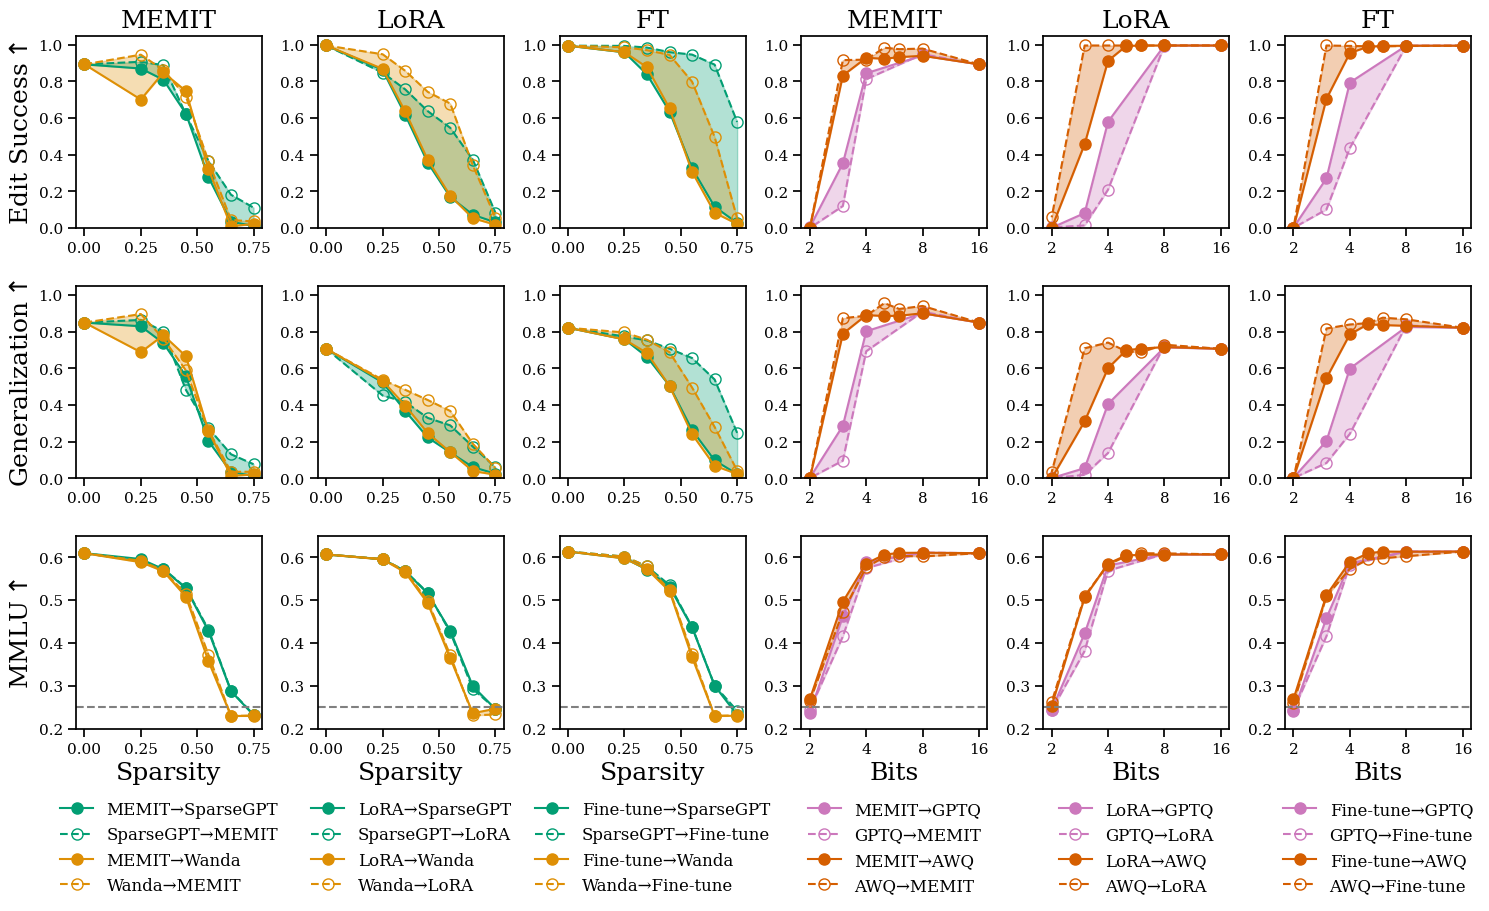

In [29]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

# 4 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(6 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "Fine-tune",
    3: "MEMIT",
    4: "LoRA",
    5: "Fine-tune"
}

compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "Fine-tune"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if x_metric == "wbits":
            ax.set_xscale("log", base=2)
            ax.set_xticks([2, 4, 8, 16], ["2", "4", "8", "16"])

        if row_index != 2:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")

        if row_index == 0:
            title = column_edit_methods[col_index] if column_edit_methods[col_index] != "Fine-tune" else "FT"
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 2:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 2:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression.pdf", bbox_inches="tight")

## Plot: Unlearning ←→ Compression

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/3391552797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/3391552797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_95229/3391552797.py

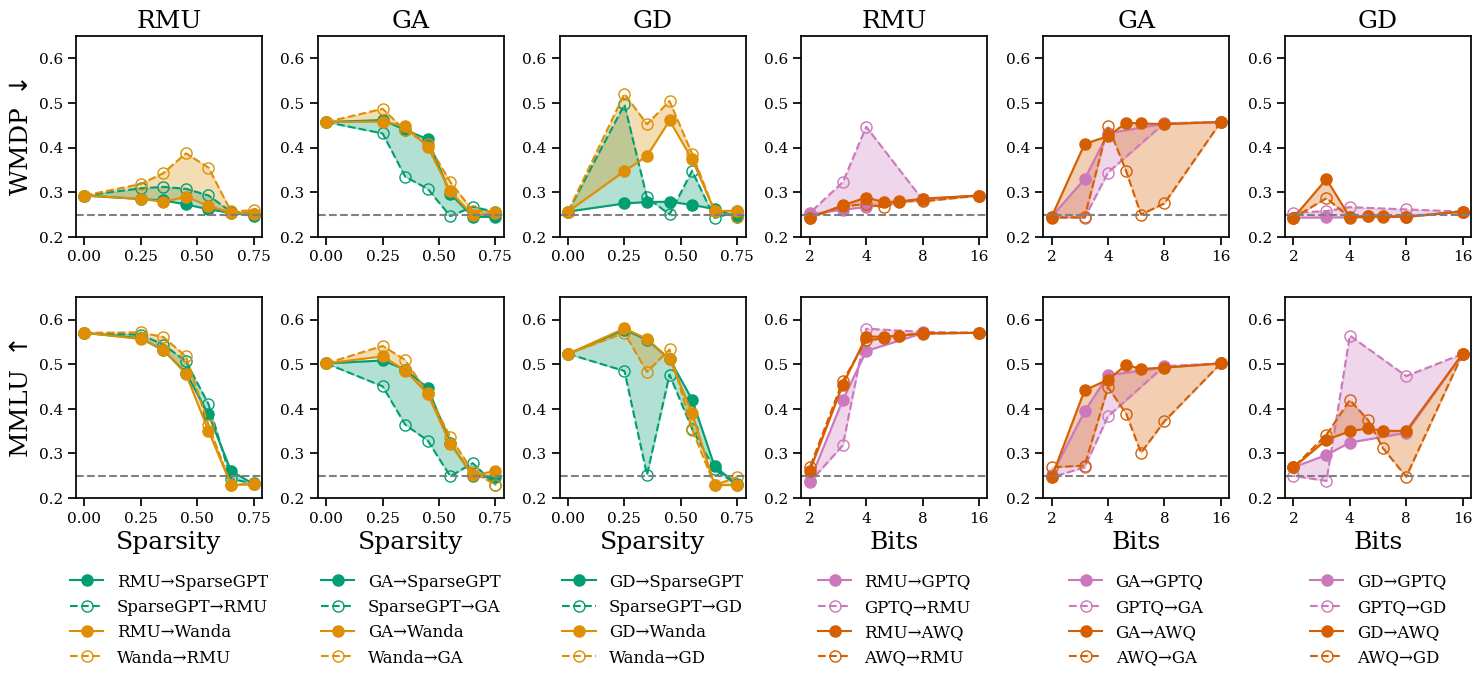

In [30]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["unlearn"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")
pruning_frame["unlearn"] = pruning_frame["unlearn"].apply(lambda x: x.upper() if x is not None else None)

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["unlearn"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["Avg WMDP"] = (quantization_frame["wmdp_bio accuracy"] + quantization_frame["wmdp_cyber accuracy"]) / 2
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")
quantization_frame["unlearn"] = quantization_frame["unlearn"].apply(lambda x: x.upper() if x is not None else None)

# 4 columns and 3 rows
fig, axes = plt.subplots(2, 6, figsize=(6 * FIG_SIZE, 2 * FIG_SIZE))
row_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
}
row_labels = {
    "Avg WMDP": r"WMDP $\downarrow$",
    "mmlu accuracy": r"MMLU $\uparrow$"
}
row_label_map = {
    0: "Avg WMDP",
    1: "mmlu accuracy"
}
column_unlearn_methods = {
    0: "RMU",
    1: "GA",
    2: "GD",
    3: "RMU",
    4: "GA",
    5: "GD",
}

compositions_by_col = {
    # RMU and WANDA + SparseGPT
    0: [("RMU→SparseGPT", "SparseGPT→RMU"), ("RMU→Wanda", "Wanda→RMU")],
    # GA and WANDA + SparseGPT
    1: [("GA→SparseGPT", "SparseGPT→GA"), ("GA→Wanda", "Wanda→GA")],
    # FT and WANDA + SparseGPT
    2: [("GD→SparseGPT", "SparseGPT→GD"), ("GD→Wanda", "Wanda→GD")],
    # RMU and GPTQ + AWQ
    3: [("RMU→GPTQ", "GPTQ→RMU"), ("RMU→AWQ", "AWQ→RMU")],
    # GA and GPTQ + AWQ
    4: [("GA→GPTQ", "GPTQ→GA"), ("GA→AWQ", "AWQ→GA")],
    # FT and GPTQ + AWQ
    5: [("GD→GPTQ", "GPTQ→GD"), ("GD→AWQ", "AWQ→GD")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["unlearn"] == column_unlearn_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["RMU", "GA", "GD"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        ax.axhline(y=0.25, color="gray", linestyle="--")
        ax.set_ylim(0.20, 0.65)

        if x_metric == "wbits":
            ax.set_xscale("log", base=2)
            ax.set_xticks([2, 4, 8, 16], ["2", "4", "8", "16"])

        if row_index == 0:
            title = column_unlearn_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[list(row_labels.keys())[row_index]], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 1:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 1:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_unlearn_compression.pdf", bbox_inches="tight")